### Finetune DINOv2 for semantic segmentation task

In [8]:
from PIL import Image
import fiftyone as fo
import numpy as np
from torchvision.transforms import v2
import torch
from create_model import LitSegmentator
import pytorch_lightning as pl
from torch.hub import load
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings("ignore")

from preprocess import coco_annotations_to_masks, resize_images_folder
import cv2

Using fiftyone to look at data

In [2]:
# A name for the dataset
name = "briges"

# The directory containing the dataset to import
RAW_IMAGES = '/home/teshbek/datasets/BrigeImages/images'
ANN_PATH = '/home/teshbek/datasets/BrigeImages/instances_default.json'

# dataset = fo.Dataset.from_dir(
#     labels_path= ANN_PATH,
#     dataset_type=fo.types.COCODetectionDataset,
#     data_path=RAW_IMAGES,
#     name=name)

In [3]:
# session = fo.launch_app(dataset)

Create segmentation masks and resize images for convenience

In [9]:
prepare_images = False
if prepare_images:
    DOWNSCALE_FACTOR = 5
    orig_masks_folder_path = coco_annotations_to_masks(ann_path=ANN_PATH, images_folder=RAW_IMAGES, ext='JPG')
    resized_images_folder_path = resize_images_folder(RAW_IMAGES, DOWNSCALE_FACTOR, ext='JPG', interpolation=cv2.INTER_AREA)
    resized_masks_folder_path = resize_images_folder(RAW_IMAGES + '_masks', DOWNSCALE_FACTOR, ext='png', interpolation=cv2.INTER_NEAREST)

Create first train and validation datasets:

In [14]:
resized_images_folder_path = '/home/teshbek/datasets/BrigeImages/images_5x_downscaled'
resized_masks_folder_path = '/home/teshbek/datasets/BrigeImages/images_masks_5x_downscaled'

all_labeled_images_names = [img for img in os.listdir(resized_images_folder_path) if os.path.isfile(os.path.join(resized_masks_folder_path, img.split(".")[0] + ".png"))]


Task:
Write a notebook (e.g Colab) that :
- Import 564 images
- Read COCO file with annotation of about 100 images (ground through)
- select N random images from those with annotation, with N a parameter from 10 to 50.
- Fine-tune (i.e. specialize) a Foundation Model (eg. SAM or other) in order to identify the defects, using the N images as training set.
- Test the performance of the specialized trained model considering the annotated images that have been not used for the training (100-N), computing some Error Score between the Ground Through and the defects identified by the trained model.
- Test the performance of the specialized trained model, drawing the polygon of the defects into some random images that were not annotated, i.e taken from the 564-100 subset.

### Loading model and saved weights

In [ ]:
from create_model import SegmentationNet
from create_model import conv_head

dino_models = {
    'dinov2_s':{
        'name':'dinov2_vits14_reg',
        'embedding_size':384,
        'patch_size':14
    },
    'dinov2_b':{
        'name':'dinov2_vitb14_reg',
        'embedding_size':768,
        'patch_size':14
    },
    'dinov2_l':{
        'name':'dinov2_vitl14',
        'embedding_size':1024,
        'patch_size':14
    },
    'dinov2_g':{
        'name':'dinov2_vitg14',
        'embedding_size':1536,
        'patch_size':14
    },
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



DINO_MODEL = dino_models['dinov2_s']
dinov2_backbone = load('facebookresearch/dinov2',  DINO_MODEL['name'])
model = SegmentationNet(backbone=dinov2_backbone, head=conv_head, embedding_size=DINO_MODEL['embedding_size'], patch_size=DINO_MODEL['patch_size'])
segmentator = LitSegmentator.load_from_checkpoint('/home/teshbek/code/Downstream-Dinov2/lightning_logs/version_11/checkpoints/epoch=29-step=150.ckpt', net=model, lr=1, weight_decay=1)

segmentator = segmentator.eval().to(device)

Using cache found in /home/teshbek/.cache/torch/hub/facebookresearch_dinov2_main


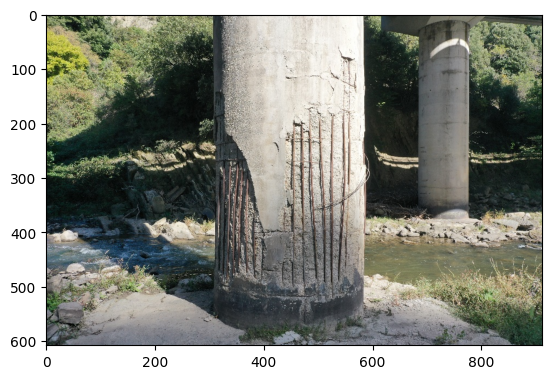

In [ ]:
image_path = "/home/teshbek/datasets/BrigeImages_6x_downscaled/DJI_0013.JPG"

img_transform = v2.Compose([
    v2.Resize((14*64,14*64)),
    v2.ToTensor(),
    v2.Normalize(mean=[102.9221/255, 105.5417/255,  97.7115/255], std=[78.5406/255, 74.1163/255, 71.4406/255]),
])
image = Image.open(image_path).convert("RGB")
transformed_image = img_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

predicted_mask = segmentator(transformed_image).cpu().detach().numpy()
# Display the image and the mask
plt.imshow(image)
plt.show()

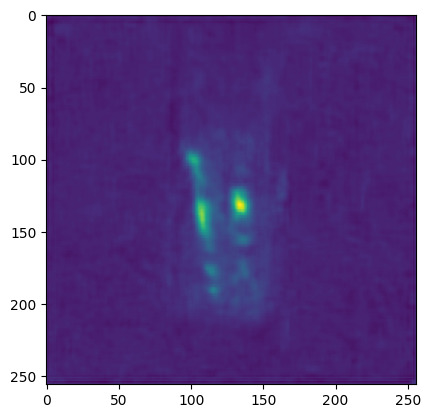

In [ ]:
plt.imshow(np.squeeze(predicted_mask)) 
plt.show()

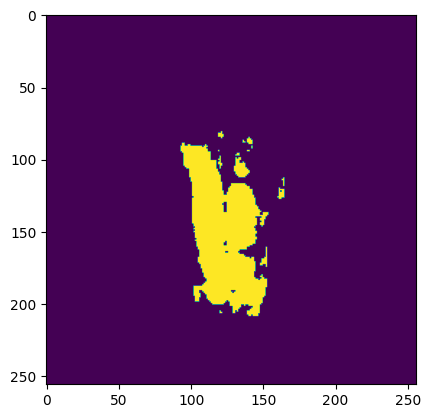

In [ ]:
plt.imshow((np.squeeze(predicted_mask)>0.5)) 
plt.show()